In [1]:
#Importing the necessary libraries
import pandas as pd
import pydot
import pystac
import fsspec
import xarray as xr
import datetime 
import numpy as np
import math
from tqdm import tqdm
from datetime import date
import pystac
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,mean_absolute_error,accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

# Load dataset

## Loading TerraClimate data from Microsoft Planetary Data Catalog

In [2]:
# Extracting data from Planetary Computer Terra Climate catalog
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [3]:
import os
os.chdir('/home/annaklumos/Projects/GitHub/EY-Challenge/')

## Loading the frog presence data from Australia

In [4]:
#Frog Presence data - 125621 records
path_frog_occur = "datasets/Australie.csv"
df_frog=pd.read_csv(path_frog_occur,usecols=['eventDate','year','month','decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"])

print(df_frog.shape)
df_frog["eventDate"] = pd.to_datetime(df_frog["eventDate"])
df_frog.head()

(125621, 7)


,occurrenceStatus,eventDate,year,month,stateProvince,decimalLatitude,decimalLongitude
0,PRESENT,2017-11-14,2017,11,Vic,-38.1,144.6
1,PRESENT,2017-11-25,2017,11,Qld,-26.7,153.1
2,PRESENT,2018-01-03,2018,1,Nsw,-30.3,152.9
3,PRESENT,2018-01-26,2018,1,Nt,-12.6,131.1
4,PRESENT,2018-02-06,2018,2,Qld,-26.3,152.9


## Loading the frog presence data from South Africa and Costa Rica

In [5]:
path_frog_occur_SA = "datasets/SA_CR.csv"
df_frog_sa = pd.read_csv(path_frog_occur_SA, usecols=['eventDate','year','month','decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"])

print(df_frog_sa.shape)
df_frog_sa["eventDate"] = pd.to_datetime(df_frog_sa["eventDate"])
df_frog_sa.head()

(6670, 7)


,occurrenceStatus,eventDate,year,month,stateProvince,decimalLatitude,decimalLongitude
0,PRESENT,2018-01-07 14:59:00,2018,1,Limón,10.438840,-83.786274
1,PRESENT,2017-11-06 08:31:00,2017,11,Mpumalanga,-24.926687,31.476465
2,PRESENT,2019-08-04 03:22:00,2019,8,Puntarenas,9.389377,-84.142044
3,PRESENT,2018-01-15 21:15:00,2018,1,Limón,10.440689,-83.785854
4,PRESENT,2018-01-04 14:22:00,2018,1,Limón,10.440703,-83.786194


## Grid based approach to extract frog count

__For calculating the frog density over Australia, South Africa and Costa Rica, we will create a grid of 225 sq. kms then we will evaluate the frog presence points of each of the grid__

### Australia

In [6]:
# Australia region bbox(excluding "Tasmania" region)
aus = {"type":"Polygon",
       "coordinates":[[[153.896484,-39.327584],[113.062499,-39.327584],
                       [113.062499,-10.521216],[153.896484,-10.521216],[153.896484,-39.327584]]]}
aus["coordinates"] = aus["coordinates"][0][0:4]
min_longi = min(aus["coordinates"])[0]
max_longi = max(aus["coordinates"])[0]
min_lati =  min(aus["coordinates"])[1]
max_lati = max(aus["coordinates"])[1]

print(aus)
print("min_lati = ",min_lati,"\n","min_longi = ",min_longi,"\n","max_lati = ",max_lati,"\n","max_longi = ",max_longi)

('Australia', (113.338953078, -43.6345972634, 153.569469029, -10.6681857235))

{'type': 'Polygon', 'coordinates': [[153.896484, -39.327584], [113.062499, -39.327584], [113.062499, -10.521216], [153.896484, -10.521216]]}
min_lati =  -39.327584 
 min_longi =  113.062499 
 max_lati =  -10.521216 
 max_longi =  153.896484


('Australia', (113.338953078, -43.6345972634, 153.569469029, -10.6681857235))

In [7]:
## Australia region bbox for "Tasmania" region
tas = {"type":"Polygon",
       "coordinates":[[[148.541748,-39.398856],[143.802246,-39.398856],
                       [143.802246,-43.69331],[148.541748,-43.69331],[148.541748,-39.398856]]]}
tas["coordinates"] = tas["coordinates"][0][0:4]

min_longi_tas = min(tas["coordinates"])[0]
max_longi_tas = max(tas["coordinates"])[0]
min_lati_tas =  min(tas["coordinates"])[1]
max_lati_tas = max(tas["coordinates"])[1]

print("min_lati = ",min_lati_tas,"\n","min_longi = ",min_longi_tas,"\n","max_lati = ",max_lati_tas,"\n","max_longi = ",max_longi_tas)

min_lati =  -43.69331 
 min_longi =  143.802246 
 max_lati =  -39.398856 
 max_longi =  148.541748


In [8]:
# Combining the whole of Australia including Tasmania region 
aus_whole = {"min_lati":min_lati_tas,"max_lati":max_lati,"min_longi":min_longi,"max_longi":max_longi}

### South Africa

In [9]:
# South Africa region bbox
sa = {"type":"Polygon",
      "bbox":[16.3449768409, -34.8191663551, 32.830120477, -22.0913127581]}
min_longi_sa = sa["bbox"][0]
max_longi_sa = sa["bbox"][2]
min_lati_sa = sa["bbox"][1]
max_lati_sa = sa["bbox"][3]

print(sa)
print("min_lati = ",min_lati_sa,"\n","min_longi = ",min_longi_sa,"\n","max_lati = ",max_lati_sa,"\n","max_longi = ",max_longi_sa)

{'type': 'Polygon', 'bbox': [16.3449768409, -34.8191663551, 32.830120477, -22.0913127581]}
min_lati =  -34.8191663551 
 min_longi =  16.3449768409 
 max_lati =  -22.0913127581 
 max_longi =  32.830120477


### Costa Rica

In [10]:
cr = {"type":"Polygon",
      "bbox":[-85.94172543, 8.22502798099, -82.5461962552, 11.2171192489]}
min_longi_cr = cr["bbox"][0]
max_longi_cr = cr["bbox"][2]
min_lati_cr = cr["bbox"][1]
max_lati_cr = cr["bbox"][3]

print(sa)
print("min_lati = ",min_lati_cr,"\n","min_longi = ",min_longi_cr,"\n","max_lati = ",max_lati_cr,"\n","max_longi = ",max_longi_cr)

{'type': 'Polygon', 'bbox': [16.3449768409, -34.8191663551, 32.830120477, -22.0913127581]}
min_lati =  8.22502798099 
 min_longi =  -85.94172543 
 max_lati =  11.2171192489 
 max_longi =  -82.5461962552


## Grid formation

### Australia

In [11]:
#Using grid based approach, creating 225 sq.kms grid, the approx. difference between lat-lon for 225 sq.kms area : lat is 0.1331 and lon is 0.15365 respectively
#66500 grids formulated for the entire region of Australia
bbox_grid_whole = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + 0.15365,4),
                     "max_y":np.round(y + .1331,4)}) for x, y in itertools.product(np.arange(aus_whole["min_longi"], aus_whole["max_longi"],0.15365),
                                                                                   np.arange(aus_whole["min_lati"], aus_whole["max_lati"],.1331))]
print(len(bbox_grid_whole))

66500


### South Africa

In [12]:
#8549 grids formulated for the entire region of South Africa
bbox_grid_whole_sa = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + 0.15365,4),
                     "max_y":np.round(y + .1331,4)}) for x, y in itertools.product(np.arange(min_longi_sa, max_longi_sa, 0.15365),
                                                                                   np.arange(min_lati_sa, max_lati_sa, .1331))]
print(len(bbox_grid_whole_sa))

10368


### Costa Rica

In [13]:
#8549 grids formulated for the entire region of South Africa
bbox_grid_whole_cr = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + 0.15365,4),
                     "max_y":np.round(y + .1331,4)}) for x, y in itertools.product(np.arange(min_longi_cr, max_longi_cr, 0.15365),
                                                                                   np.arange(min_lati_cr, max_lati_cr, .1331))]
print(len(bbox_grid_whole_cr))

529


## Frog count column formation from frog_id dataset

### Australia

In [14]:
# Calculate the frog count (greater than 0) by iterating through each of the grid and subsetting frog presence data, 
#append to a dictionary with bounding box coordinates and shape of the subset data as - frog count
filt_lat = {}
i=1
for _,bbox in tqdm(enumerate(bbox_grid_whole)):  
    longi_lati_df_rang = df_frog[((df_frog['decimalLongitude'] >= bbox["min_x"]) & (df_frog['decimalLongitude'] <= bbox["max_x"])) & 
                           ((df_frog['decimalLatitude'] >= bbox["min_y"]) & (df_frog['decimalLatitude'] <=bbox["max_y"]))]
    if longi_lati_df_rang.shape[0]>0:
        filt_lat[i] ={}
        filt_lat[i]["coord"] = bbox
        filt_lat[i]["frog_count"] = longi_lati_df_rang.shape[0]
        i=i+1
aus_whole_filt_cord = filt_lat

66500it [01:43, 643.83it/s]


### South Africa

In [15]:
filt_lat = {}
i=1
for _,bbox in tqdm(enumerate(bbox_grid_whole_sa)):  
    longi_lati_df_rang = df_frog_sa[((df_frog_sa['decimalLongitude'] >= bbox["min_x"]) & (df_frog_sa['decimalLongitude'] <= bbox["max_x"])) & 
                           ((df_frog_sa['decimalLatitude'] >= bbox["min_y"]) & (df_frog_sa['decimalLatitude'] <=bbox["max_y"]))]
    if longi_lati_df_rang.shape[0]>0:
        filt_lat[i] ={}
        filt_lat[i]["coord"] = bbox
        filt_lat[i]["frog_count"] = longi_lati_df_rang.shape[0]
        i=i+1
sa_whole_filt_cord = filt_lat

10368it [00:07, 1301.68it/s]


### Costa Rica

In [16]:
filt_lat = {}
i=1
for _,bbox in tqdm(enumerate(bbox_grid_whole_cr)):  
    longi_lati_df_rang = df_frog_sa[((df_frog_sa['decimalLongitude'] >= bbox["min_x"]) & (df_frog_sa['decimalLongitude'] <= bbox["max_x"])) & 
                           ((df_frog_sa['decimalLatitude'] >= bbox["min_y"]) & (df_frog_sa['decimalLatitude'] <=bbox["max_y"]))]
    if longi_lati_df_rang.shape[0]>0:
        filt_lat[i] ={}
        filt_lat[i]["coord"] = bbox
        filt_lat[i]["frog_count"] = longi_lati_df_rang.shape[0]
        i=i+1
cr_whole_filt_cord = filt_lat

529it [00:00, 1274.29it/s]


In [17]:
# Sample dictionary with bounding box and frog count
dict(list(aus_whole_filt_cord.items())[0:2])
dict(list(sa_whole_filt_cord.items())[0:2])
dict(list(cr_whole_filt_cord.items())[0:2])

{1: {'coord': {'min_x': -85.9417,
   'min_y': 10.0884,
   'max_x': -85.7881,
   'max_y': 10.2215},
  'frog_count': 1},
 2: {'coord': {'min_x': -85.9417,
   'min_y': 10.2215,
   'max_x': -85.7881,
   'max_y': 10.3546},
  'frog_count': 2}}

In [18]:
# Converting the frog_id dictionary to dataframe having 2660 rows & 6 columns
aus_whole_filt_cord_df = pd.DataFrame.from_dict(aus_whole_filt_cord,orient="index")

aus_whole_filt_cord_df["min_lon"] = [i["min_x"] for i in aus_whole_filt_cord_df["coord"]]
aus_whole_filt_cord_df["min_lat"] = [i["min_y"] for i in aus_whole_filt_cord_df["coord"]]

aus_whole_filt_cord_df["max_lon"] = [i["max_x"] for i in aus_whole_filt_cord_df["coord"]]
aus_whole_filt_cord_df["max_lat"] = [i["max_y"] for i in aus_whole_filt_cord_df["coord"]]


print(aus_whole_filt_cord_df.shape)
aus_whole_filt_cord_df.head()

(2660, 6)


,coord,frog_count,min_lon,min_lat,max_lon,max_lat
1,"{'min_x': 113.6771, 'min_y': -24.9262, 'max_x'...",1,113.6771,-24.9262,113.8307,-24.7931
2,"{'min_x': 114.138, 'min_y': -27.7213, 'max_x':...",8,114.1380,-27.7213,114.2917,-27.5882
3,"{'min_x': 114.599, 'min_y': -28.9192, 'max_x':...",3,114.5990,-28.9192,114.7526,-28.7861
4,"{'min_x': 114.599, 'min_y': -28.7861, 'max_x':...",28,114.5990,-28.7861,114.7526,-28.6530
5,"{'min_x': 114.599, 'min_y': -28.653, 'max_x': ...",35,114.5990,-28.6530,114.7526,-28.5199


In [19]:
sa_whole_filt_cord_df = pd.DataFrame.from_dict(sa_whole_filt_cord,orient="index")

sa_whole_filt_cord_df["min_lon"] = [i["min_x"] for i in sa_whole_filt_cord_df["coord"]]
sa_whole_filt_cord_df["min_lat"] = [i["min_y"] for i in sa_whole_filt_cord_df["coord"]]

sa_whole_filt_cord_df["max_lon"] = [i["max_x"] for i in sa_whole_filt_cord_df["coord"]]
sa_whole_filt_cord_df["max_lat"] = [i["max_y"] for i in sa_whole_filt_cord_df["coord"]]


print(sa_whole_filt_cord_df.shape)
sa_whole_filt_cord_df.head()

(505, 6)


,coord,frog_count,min_lon,min_lat,max_lon,max_lat
1,"{'min_x': 17.5742, 'min_y': -30.0276, 'max_x':...",1,17.5742,-30.0276,17.7278,-29.8945
2,"{'min_x': 17.8815, 'min_y': -33.4882, 'max_x':...",1,17.8815,-33.4882,18.0351,-33.3551
3,"{'min_x': 17.8815, 'min_y': -30.2938, 'max_x':...",1,17.8815,-30.2938,18.0351,-30.1607
4,"{'min_x': 17.8815, 'min_y': -30.1607, 'max_x':...",1,17.8815,-30.1607,18.0351,-30.0276
5,"{'min_x': 18.0351, 'min_y': -33.222, 'max_x': ...",1,18.0351,-33.2220,18.1888,-33.0889


In [20]:
cr_whole_filt_cord_df = pd.DataFrame.from_dict(cr_whole_filt_cord,orient="index")

cr_whole_filt_cord_df["min_lon"] = [i["min_x"] for i in cr_whole_filt_cord_df["coord"]]
cr_whole_filt_cord_df["min_lat"] = [i["min_y"] for i in cr_whole_filt_cord_df["coord"]]

cr_whole_filt_cord_df["max_lon"] = [i["max_x"] for i in cr_whole_filt_cord_df["coord"]]
cr_whole_filt_cord_df["max_lat"] = [i["max_y"] for i in cr_whole_filt_cord_df["coord"]]


print(cr_whole_filt_cord_df.shape)
cr_whole_filt_cord_df.head()

(174, 6)


,coord,frog_count,min_lon,min_lat,max_lon,max_lat
1,"{'min_x': -85.9417, 'min_y': 10.0884, 'max_x':...",1,-85.9417,10.0884,-85.7881,10.2215
2,"{'min_x': -85.9417, 'min_y': 10.2215, 'max_x':...",2,-85.9417,10.2215,-85.7881,10.3546
3,"{'min_x': -85.7881, 'min_y': 9.8222, 'max_x': ...",2,-85.7881,9.8222,-85.6344,9.9553
4,"{'min_x': -85.7881, 'min_y': 9.9553, 'max_x': ...",1,-85.7881,9.9553,-85.6344,10.0884
5,"{'min_x': -85.7881, 'min_y': 10.3546, 'max_x':...",1,-85.7881,10.3546,-85.6344,10.4877


# Averaging the TerraClimate variables across the Grids

Les données sont accumulés par variable cible sur les deux ans, chercher peut-être à ajouter une variable temporelle

## Australia grid

In [21]:
# Selecting time frame based on frogid dataset
ds_date = ds.sel(time = slice("2017-11-01","2019-11-01"))

# filtering data for Austrlia region based on coordinates
ds_aus = ds_date.where((ds.lat>=aus_whole["min_lati"]) & (ds.lat<=aus_whole["max_lati"]) & 
                       ((ds.lon>=aus_whole["min_longi"] ) & (ds.lon<=aus_whole["max_longi"])),drop = True)

#  Converting the xarray format to pandas dataframe 
ds_aus = ds_aus.to_dataframe().reset_index()

ds_aus["time"] = pd.to_datetime(ds_aus["time"])

In [22]:
# Iterate the Terra climate lat-lon across the grids for averaging the terraclimate values for a particular lat-Lon
for ind,row in tqdm(aus_whole_filt_cord_df.iterrows()):

    
    longi_lati_df_rang = ds_aus[(ds_aus['lon'] >= row["min_lon"]) & (ds_aus['lon'] <= row["max_lon"]) & 
                           (ds_aus['lat'] >= row["min_lat"]) & (ds_aus['lat'] <=row["max_lat"])]
    
    
    col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]
    
    for var in col:
        for key,val in var.items():
#             print(key,val)
            aus_whole_filt_cord_df.loc[ind,key] = val
    
    aus_whole_filt_cord_df.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]

2660it [04:22, 10.15it/s]


## South Africa Grid

In [23]:
# filtering data for Austrlia region based on coordinates
ds_sa = ds_date.where((ds.lat>=min_lati_sa) & (ds.lat<=max_lati_sa) & 
                       ((ds.lon>=min_longi_sa ) & (ds.lon<=max_longi_sa)),drop = True)

#  Converting the xarray format to pandas dataframe 
ds_sa = ds_sa.to_dataframe().reset_index()

ds_sa["time"] = pd.to_datetime(ds_sa["time"])

In [24]:
# Iterate the Terra climate lat-lon across the grids for averaging the terraclimate values for a particular lat-Lon
for ind,row in tqdm(sa_whole_filt_cord_df.iterrows()):

    
    longi_lati_df_rang = ds_sa[(ds_sa['lon'] >= row["min_lon"]) & (ds_sa['lon'] <= row["max_lon"]) & 
                           (ds_sa['lat'] >= row["min_lat"]) & (ds_sa['lat'] <=row["max_lat"])]
    
    
    col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]
    
    for var in col:
        for key,val in var.items():
#             print(key,val)
            sa_whole_filt_cord_df.loc[ind,key] = val
    
    sa_whole_filt_cord_df.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]

505it [00:11, 45.05it/s]


## Costa Rica Grid

In [25]:
# filtering data for Austrlia region based on coordinates
ds_cr = ds_date.where((ds.lat>=min_lati_cr) & (ds.lat<=max_lati_cr) & 
                       ((ds.lon>=min_longi_cr ) & (ds.lon<=max_longi_cr)),drop = True)

#  Converting the xarray format to pandas dataframe 
ds_cr = ds_cr.to_dataframe().reset_index()

ds_cr["time"] = pd.to_datetime(ds_cr["time"])

In [26]:
# Iterate the Terra climate lat-lon across the grids for averaging the terraclimate values for a particular lat-Lon
for ind,row in tqdm(cr_whole_filt_cord_df.iterrows()):

    
    longi_lati_df_rang = ds_cr[(ds_cr['lon'] >= row["min_lon"]) & (ds_cr['lon'] <= row["max_lon"]) & 
                           (ds_cr['lat'] >= row["min_lat"]) & (ds_cr['lat'] <=row["max_lat"])]
    
    
    col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]
    
    for var in col:
        for key,val in var.items():
#             print(key,val)
            sa_whole_filt_cord_df.loc[ind,key] = val
    
    cr_whole_filt_cord_df.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]

174it [00:01, 134.66it/s]


## Data preprocessing for regression based model building

In [27]:
# Copying 'aus_whole_filt_cord_df' to new variable - 'df_aus_225_2yr'
df_225_2yr = pd.concat([aus_whole_filt_cord_df, sa_whole_filt_cord_df, cr_whole_filt_cord_df])
df_225_2yr.head(2)

,coord,frog_count,min_lon,min_lat,max_lon,max_lat,aet,def,pdsi,pet,...,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws,samples_count
1,"{'min_x': 113.6771, 'min_y': -24.9262, 'max_x'...",1,113.6771,-24.9262,113.8307,-24.7931,12.150000,181.350006,-2.382000,193.516663,...,0.0,29.463333,0.0,18.459324,0.0,1.465966,0.0,1.715933,4.609332,300.0
2,"{'min_x': 114.138, 'min_y': -27.7213, 'max_x':...",8,114.1380,-27.7213,114.2917,-27.5882,17.793333,148.386673,-4.157999,166.083328,...,0.0,28.077656,0.0,14.859997,0.0,1.497400,0.0,1.316767,4.691668,300.0


In [28]:
# Data preprocessing

# selecting relevant columns and appending frog count column
sel_col = df_225_2yr.columns[6:].to_list()
sel_col.extend(["frog_count"])
print(len(sel_col))

# delete the 'samples_count' column
df_model_data = df_225_2yr[sel_col]
del df_model_data["samples_count"]
df_model_data.head(2)


20


,aet,def,pdsi,pet,ppt,ppt_station_influence,q,soil,srad,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws,frog_count
1,12.150000,181.350006,-2.382000,193.516663,12.783334,0.0,0.613333,1.320000,262.563324,0.0,29.463333,0.0,18.459324,0.0,1.465966,0.0,1.715933,4.609332,1
2,17.793333,148.386673,-4.157999,166.083328,18.896667,0.0,0.860000,6.053333,246.456665,0.0,28.077656,0.0,14.859997,0.0,1.497400,0.0,1.316767,4.691668,8


In [29]:
# Checking for missing values % for respective variables
for col in df_model_data.columns:
    miss_value_number = df_model_data[col].isna().sum()
    mis = ((df_model_data[col].isna().sum())/df_model_data[col].shape[0])*100
    print("missing valuein {} : is {} ---> {}%".format(col,miss_value_number,mis))

missing valuein aet : is 187 ---> 5.600479185384845%
missing valuein def : is 187 ---> 5.600479185384845%
missing valuein pdsi : is 187 ---> 5.600479185384845%
missing valuein pet : is 187 ---> 5.600479185384845%
missing valuein ppt : is 187 ---> 5.600479185384845%
missing valuein ppt_station_influence : is 175 ---> 5.2410901467505235%
missing valuein q : is 187 ---> 5.600479185384845%
missing valuein soil : is 187 ---> 5.600479185384845%
missing valuein srad : is 187 ---> 5.600479185384845%
missing valuein swe : is 187 ---> 5.600479185384845%
missing valuein tmax : is 187 ---> 5.600479185384845%
missing valuein tmax_station_influence : is 175 ---> 5.2410901467505235%
missing valuein tmin : is 187 ---> 5.600479185384845%
missing valuein tmin_station_influence : is 175 ---> 5.2410901467505235%
missing valuein vap : is 187 ---> 5.600479185384845%
missing valuein vap_station_influence : is 175 ---> 5.2410901467505235%
missing valuein vpd : is 187 ---> 5.600479185384845%
missing valuein ws

In [30]:
# Revalidating missing values for "soil" variable
df_model_data[df_model_data["def"].isna()]

,aet,def,pdsi,pet,ppt,ppt_station_influence,q,soil,srad,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws,frog_count
1527,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,22
1958,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,8
2053,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,1
2131,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,5
2362,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [31]:
# Original shape of dataset
df_model_data.shape

(3339, 19)

In [32]:
# Dropping missing values and checking the final shape of data (2655,19)
df_model_data = df_model_data.dropna()
df_model_data.shape

(3152, 19)

In [33]:
# Outliers capping for treating outliers
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

df_model_data.iloc[:,0:-1]=df_model_data.iloc[:,0:-1].apply(lambda x: outlier_capping(x))

In [34]:
# Checking unique values for the below columns
df_model_data[["ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence"]].value_counts().reset_index(name='Count')

,ppt_station_influence,vap_station_influence,tmax_station_influence,tmin_station_influence,Count
0,0.0,0.0,0.0,0.0,3152


In [35]:
# Dropping columns with only 0 values in the weather data
df_model_data.drop(["ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence"],
                   axis=1, inplace=True)

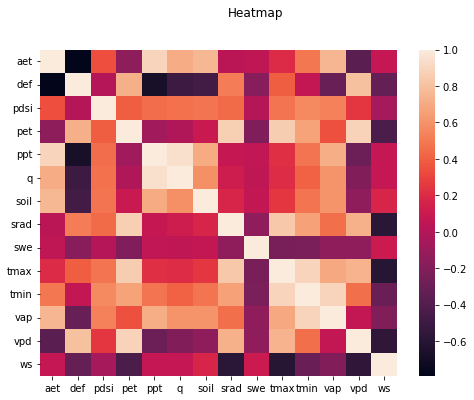

In [36]:
# Correlation matrix visualization
plt.figure(figsize=(8,6))
sns.heatmap(df_model_data.iloc[:,0:-1].corr())
plt.suptitle('Heatmap')
plt.show()

In [37]:
# Data distribution of column - 'swe'
df_model_data['swe'].value_counts()

0.000000    3074
0.756567      32
0.004444       4
0.010000       3
0.497500       2
0.013333       2
0.036667       2
0.587500       1
0.390000       1
0.213333       1
0.080000       1
0.724444       1
0.096667       1
0.380000       1
0.112500       1
0.006667       1
0.470000       1
0.324444       1
0.644444       1
0.351111       1
0.017500       1
0.050000       1
0.017778       1
0.016667       1
0.556667       1
0.126667       1
0.676667       1
0.076667       1
0.403333       1
0.191111       1
0.146667       1
0.020000       1
0.056667       1
0.460000       1
0.593333       1
0.002500       1
0.524444       1
0.536667       1
0.137500       1
0.003333       1
Name: swe, dtype: int64

In [38]:
# Dropping column - 'swe' as most of the values are 0
df_model_data.drop(["swe"],axis = 1,inplace = True)

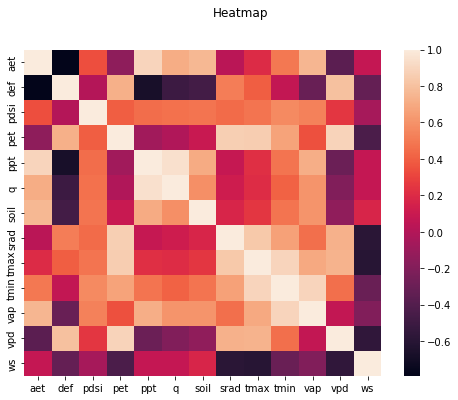

In [39]:
# Correlation matrix visualization
plt.figure(figsize=(8,6))
sns.heatmap(df_model_data.iloc[:,0:-1].corr())
plt.suptitle('Heatmap')
plt.show()

In [40]:
df_model_data['frog_count'].value_counts()

1      658
2      361
3      246
4      170
5      135
      ... 
288      1
860      1
551      1
253      1
155      1
Name: frog_count, Length: 278, dtype: int64

In [41]:
df_model_data.head()

,aet,def,pdsi,pet,ppt,q,soil,srad,tmax,tmin,vap,vpd,ws,frog_count
1,12.420175,171.888867,-2.382000,189.150980,13.032900,0.633875,1.320000,262.563324,29.463333,18.459324,1.465966,1.715933,4.609332,1
2,17.793333,148.386673,-4.157999,166.083328,18.896667,0.860000,6.053333,246.456665,28.077656,14.859997,1.497400,1.316767,4.691668,8
3,23.292000,136.475998,-3.880400,159.731995,24.799999,1.172000,12.356000,236.783997,27.145990,14.220003,1.506880,1.149360,5.230801,3
4,23.063334,137.653336,-3.828666,160.649994,24.556667,1.156667,11.950000,236.729996,27.151005,14.185001,1.485367,1.165100,5.191999,28
5,23.352501,138.470001,-3.817252,161.797501,24.860001,1.177500,13.085000,237.410004,27.017490,13.894751,1.434500,1.181100,5.133749,35


## Outliers treatments for Target variable

<AxesSubplot:xlabel='frog_count'>

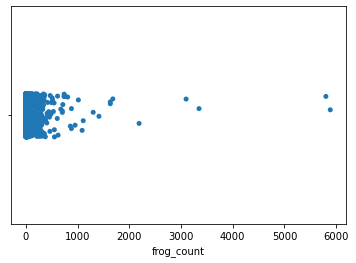

In [42]:
# Visulalisation for selecting the frog count
import seaborn as sns
sns.stripplot(df_model_data['frog_count'])

In [43]:
# Setting upper limit as less than 500 for frog count 
upper = 500
df_model_data = df_model_data[(df_model_data['frog_count'] < upper)]

## Model building

In [44]:
# Splitting the feature and target set to x and y
x = df_model_data.iloc[:,0:-1]
y = df_model_data["frog_count"].values
n_features = x.shape[1]
print('Number of features : ', n_features)

# Change target variable into class
y_class = LabelEncoder().fit_transform(y)
n_class = len(np.unique(y_class))
print('Number of classes : ', n_class)

Number of features :  13
Number of classes :  246


In [45]:
# Spliting the data into training and validation set based on 70-30 ratio
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(x, y, y_class, test_size=0.33, random_state=1)

In [46]:
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(y_train_class.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_class.shape)

(2088, 13)
(2088,)
(2088,)
(1029, 13)
(1029,)
(1029,)


### Model normalization using minmaxscaler

In [47]:
# Data normalization using Minmaxscaler
mm_scaler = StandardScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

In [48]:
# Generating VIF scores & dropping variables having high VIF to avoid multicollinearity
F = pd.DataFrame(X_train_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = F.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(F.values, i) for i in range(len(F.columns))]

print(vif_data)

  feature       VIF
0     aet  6.641482
1    pdsi  1.898947
2       q  2.243216
3    soil  3.087495
4     vap  3.736964
5     vpd  2.658515
6      ws  1.850484


In [49]:
# Dropping columns based on VIF score > 50
X_train_mm=pd.DataFrame(X_train_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
X_train_mm=X_train_mm.values
X_test_mm=pd.DataFrame(X_test_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
X_test_mm=X_test_mm.values

In [50]:
n_train_class = len(np.unique(y_train_class))
print('Number of classes : ', n_train_class)

Number of classes :  205


### Model checkpoint & building the architecture

In [65]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath='alternate_best_model_adam_225_2yr_updated_VIF.hdf5',
                             monitor='clas_loss',verbose=1,save_weights_only=True,save_best_only=True,mode='min')

# def Log():
#     inp = Sequential()
#     output = Dense(10, activation=tf.nn.softmax)(inp)
#     return Model(inp, output, name='Log')
    

# model architecture for ANN model

inp = Input(shape=(7,))
hidden1 = Dense(512, activation="relu", kernel_initializer='he_normal')(inp)
hidden2 = Dense(256, activation="relu", kernel_initializer='he_normal')(hidden1)
hidden3 = Dense(128, activation="relu", kernel_initializer='he_normal')(hidden2)
hidden4 = Dense(64, activation="relu", kernel_initializer='he_normal')(hidden3)
hidden5 = Dense(32, activation="relu", kernel_initializer='he_normal')(hidden4)
hidden6 = Dense(16, activation="relu", kernel_initializer='he_normal')(hidden5)
hidden7 = Dense(8, activation="relu", kernel_initializer='he_normal')(hidden6)
# Regression output
out_reg = Dense(1, activation="linear", name='reg')(hidden7)
# Classifier output
out_clas = Dense(n_class, activation='softmax', name='clas')(hidden7)

# Define model
model = Model(inputs=inp, outputs=[out_reg, out_clas])

# Plot graph of model
plot_model(model, to_file='model.png', show_shapes=True)

# Compile model: The model is initialized with the Adam optimizer and then it is compiled
model.compile(loss=['mae','sparse_categorical_crossentropy'], optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='clas_loss', mode='min', verbose=1, patience=100)

# Fitting the model on train data
history = model.fit(X_train_mm, [y_train, y_train_class], epochs=10000, batch_size=128,
                    verbose=2, callbacks=[es,checkpoint])

Epoch 1/10000
17/17 - 1s - loss: 29.6404 - reg_loss: 23.9036 - clas_loss: 5.7369

Epoch 00001: clas_loss improved from inf to 5.73689, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 2/10000
17/17 - 0s - loss: 28.7658 - reg_loss: 23.1164 - clas_loss: 5.6494

Epoch 00002: clas_loss improved from 5.73689 to 5.64939, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 3/10000
17/17 - 0s - loss: 28.2737 - reg_loss: 22.8677 - clas_loss: 5.4060

Epoch 00003: clas_loss improved from 5.64939 to 5.40595, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 4/10000
17/17 - 0s - loss: 27.9140 - reg_loss: 22.7752 - clas_loss: 5.1388

Epoch 00004: clas_loss improved from 5.40595 to 5.13877, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 5/10000
17/17 - 0s - loss: 27.5015 - reg_loss: 22.6122 - clas_loss: 4.8893

Epoch 00005: clas_loss improved from 5.13877 to 4.88930, saving model to alternate_best_model_adam

KeyboardInterrupt: 

## Model Result & Analysis

In [66]:
# Make predictions on test set
yhat1, yhat2 = model.predict(X_test_mm)
# Calculate error for regression model
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)
# Evaluate accuracy for classification model
yhat2 = np.argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

MAE: 25.400
Accuracy: 0.101


In [72]:
print(y_train_class.shape)
print(X_train_mm.shape)
print(X_test_mm.shape)

(2088,)
(2088, 7)
(1029, 7)


In [89]:
# Validation Score by loading latest checkpoint saved
model.load_weights("alternate_best_model_adam_225_2yr_updated_VIF.hdf5")
PredTestSet = model.predict(X_test_mm)

# calculate train Rsquare
PredTrainSet = model.predict(X_train_mm)
train_R2 = r2_score(y_train_class, PredTrainSet[0])
print('train_R2:{}'.format(train_R2))

# calculate validate Rsquare
validation_R2 = r2_score(y_test_class, PredTestSet[0])
print('validation_R2:{}'.format(validation_R2))

train_R2:0.7707627871937863
validation_R2:-0.15958242799785238


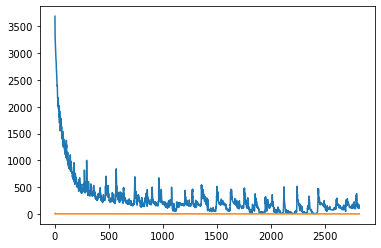

In [87]:
# Training loss vs Validation loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['clas_loss'])

### 1. Feature Importance

In [84]:
# Feature importance for model
import dalex as dx
explainer = dx.Explainer(model, X_train_mm, y_train, y_train_class, label='frog_count')
features = x.drop(['ppt','tmax','tmin','pet','def','srad'],axis=1).columns.to_list()
features

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 2088 rows 7 cols
  -> target variable   : 2088 values
  -> model_class       : tensorflow.python.keras.engine.functional.Functional (default)
  -> label             : frog_count
  -> predict function  : [ 2 11  0 ... 10  0  4] will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
'numpy.ndarray' object is not callable
  -> model_info        : package tensorflow

A new explainer has been created!


['aet', 'pdsi', 'q', 'soil', 'vap', 'vpd', 'ws']

In [85]:
# Generating dict to identlfy the feature names in the below visualization
di = {}
i = 0
for each in features:
    di[i] = each
    i=i+1
di

{0: 'aet', 1: 'pdsi', 2: 'q', 3: 'soil', 4: 'vap', 5: 'vpd', 6: 'ws'}

In [86]:
#plotting the variable importance chart
explainer.model_parts().plot()

TypeError: 'numpy.ndarray' object is not callable

# Make a submission file

In [91]:
df_sub=pd.read_csv('templates/submission_template_file.csv')
print(df_sub.shape)
df_sub.head()

(182, 6)


,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
0,1,133.9014,-27.1322,134.1738,-26.8813,NaN
1,2,134.1738,-32.9015,134.4463,-32.6506,NaN
2,3,134.9912,-32.9015,135.2637,-32.6506,NaN
3,4,135.2637,-34.6574,135.5361,-34.4065,NaN
4,5,135.2637,-34.1557,135.5361,-33.9048,NaN


In [ ]:
df_sub_test = df_sub.iloc[:,0:-1]
df_sub_test.head()

ds_sub = ds.to_dataframe().reset_index()
for ind,row in tqdm(df_sub_test.iterrows()):
    
    longi_lati_df_rang = ds_sub[(ds_sub['lon'] >= row["min_lon"]) & (ds_sub['lon'] <= row["max_lon"]) & 
                           (ds_sub['lat'] >= row["min_lat"]) & (ds_sub['lat'] <=row["max_lat"])]
    
    
    col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]
    
    for var in col:
        for key,val in var.items():
#             print(key,val)
            df_sub_test.loc[ind,key] = val
    
    df_sub_test.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]